# Histopathologic Cancer Detection

The goal behind this notebokk was to learn about developing and implementing convolutional neural networks (CNNs) as part of a Data Science coursework. The topic of the notebook is going to be the detection of cancer cells.

Cancer is the abnormal growth of cells. Cancer can spread to other parts of the body and has the potential to be fatal to an individual. There is great importance in not only finding a cure for cancer but also to find early detection methods in order to mitigate future injuries and damage to a person. This notebook will aim to use deep learning to detect the presence of cancer.

Provided by Kaggle, a set of images are used to try to train a deep learning model with the purpose of detecting cancer. The images are 96x96 pixel microscope images with labels as 0 or 1; 0 indicating the absence of cancer, and 1 is the presence of cancer. The image labels are defined by a pixel of cancer found on a 32x32 boundary at the center of the image. Each image is a colored image, i.e. in RGB. That would mean there is going to be 3 layers of red, blue and green values.

The images will be training through a convolutional neural network to predict an outcome given an image.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

from tifffile import imread
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_path = './train/'
test_path = './test/'
sample = pd.read_csv('sample_submission.csv')
train_labels = pd.read_csv('train_labels.csv')

In [3]:
sample.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


It looks like the train_labels.csv file consists of 2 columns: the id which is the file name of the image and the labels (presence/absence of cancer).

In [4]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


There is a lot of images in the training set - 220,025 image. There does not seem to be any missing or null values indicated from the dataframe summary above.

Just some minor preparations for the model, we are going to add the file type at the end of each file name in the dataframe so we don't have to manually add it later on for each file. We are also going to change the labels column into a string column instead of leaving it as an integer because categorical variables need to be as string values for the model to interpret. 

In [6]:
# preparing cols for image training
train_labels.label = train_labels.label.astype(str)
train_labels.id = train_labels.id + '.tif'

Reading the first image in the training dataframe, we see a sample image. The image size is also printed and we can confirm that the image is indeed a 96 x 96 image with 3 channels.

(96, 96, 3)


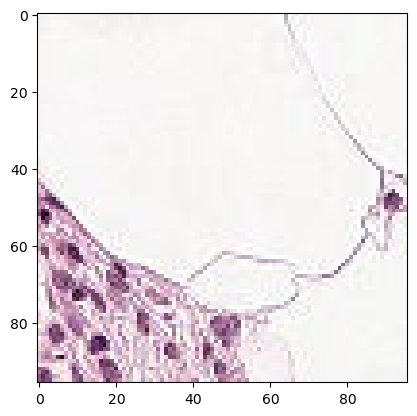

In [7]:
sample_im = imread(train_path + train_labels['id'][0]) # getting sample image from train folder
print(sample_im.shape) # looking at shape of image

plt.imshow(sample_im)
plt.show()

Looking at the total label counts in the training set we see that there are a lot more images showing the absence of cancer. We are going to keep the data size as is because it does not seem to be such a drastic difference - there is a lot for both labels with 8000+ images. 

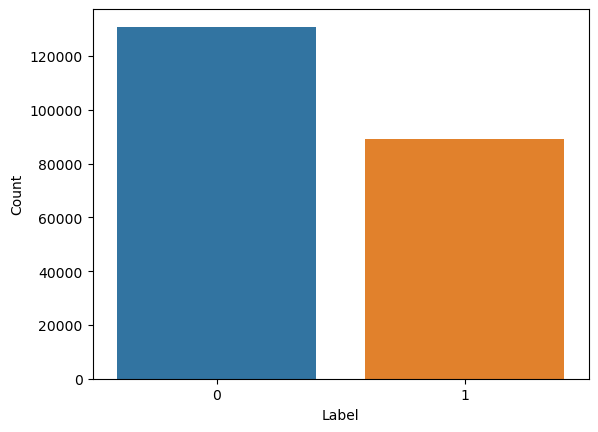

In [8]:
value_count = train_labels.label.value_counts()

sns.barplot(x=value_count.index, y=value_count[:])
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
def plot_image(rows, cols, label):
    rows, cols = rows, cols
    fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
    
    # taking a couple samples with corresponding label
    cancer_samples = train_labels[train_labels.label==label].sample(rows*cols, random_state=57).index
    print(cancer_samples[3])

    for i in range(rows*cols):
        image = imread(train_path + train_labels.iloc[cancer_samples[i]].id)

        row, col = i//rows, i%cols
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        
        # drawing the 32x32 rectangle focus on image
        box = patches.Rectangle((32,32), 32, 32, linewidth=2, edgecolor='lime',
                               facecolor='none')
        axes[row, col].add_patch(box)
        plt.tight_layout()
    if label == 0:
        plt.suptitle(f'Cells Without Cancer (Label={label})', y=1)
    else:
        plt.suptitle(f'Cells With Cancer (Label={label})', y=1)
    plt.show()

205967


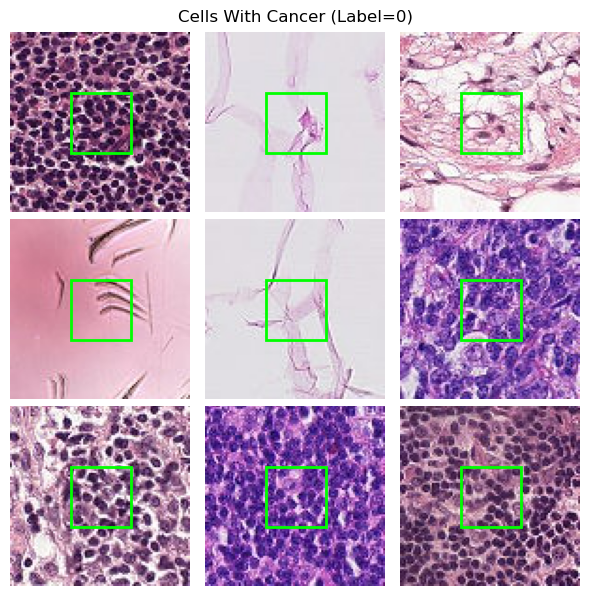

In [10]:
plot_image(3, 3, '0')

Above we see sample images of the images in the absence of cancer. The green box highlights the area that the labels are being based on - whether cancer is within that area or not.

The process is performed below for images with the presence of cancer. It's difficult to determine "cancer" in these cells without the domain knowledge. But we know according to the description of the Kaggle dataset that these images have at least 1 pixel of cancer within the green boxes.

212608


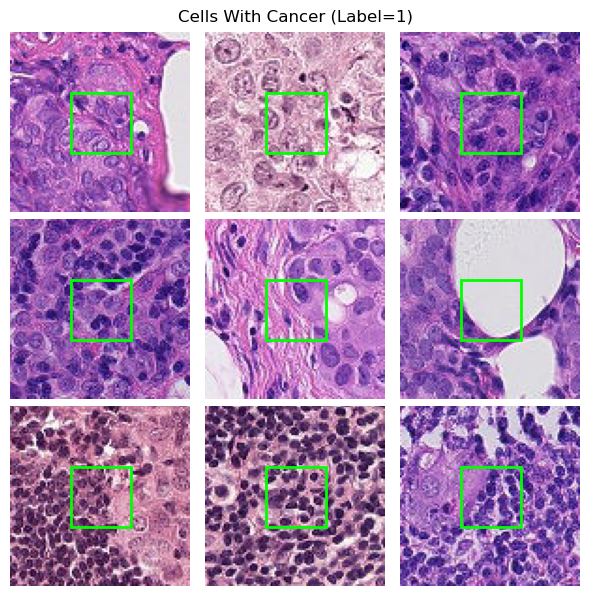

In [11]:
plot_image(3, 3, '1')

## Model Development

Here we begin creating the training data and developing a convolutional neural network (CNN) to detect cancer cells from the images. The training data set will be split into training and valiation with a 8/2 split - 80% training, 20% validation. 

We are going to start off with a generic CNN structure. The model is going to be simple VGG-esque-model with 2 Convolutional layers and 1 pooling layer. This is going to be flatten and sent into a Dense layer with 256 nodes and finally into a final Dense layer where the binary output will be given - 0 for absence, 1 for presence of cancer. The activation will be the 'relu' function for all convolution layers and dense layers besides the final dense layer which is going to be a sigmoid function.

The Conv layers will have filters 25 and kernel size of 3x3.

The model is going to be running with the 'adam' optimizer using the binary crossentropy loss and the accuracy will be the metric to look at alongside loss. 

In summary the initial model is going to be:

$[CNN, CNN, Pool] -> Dense(256) -> Dense(1)$

An initial VGG-model with a filter of 3x3 is what was chosen as our base model because the 3x3 filter is able to capture more aspects of the image compared to bigger filters which summarizes a larger space which may lose out on some information. Considering that the cancer cell may be very small in the image, I think it a good idea to start with a 3x3 filter and it is known that the VGG architecture produced good results so I wanted to use that as a base model.

In [15]:
batch_size = 256

Notice that the target_size parameter is set to a (48 x 48) which means that the images are going to be resized into a 48x48 image instead of remaining as a 96x96. This is to help quicken the pace of the training because earlier trials took too long. 

In [16]:
# normalizing the images and creating a validation split
image_gen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

# obtaining training data
train_data = image_gen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_path,
    x_col='id',
    y_col='label',
    target_size=(48, 48),
    subset='training',
    class_mode='binary',
    batch_size=batch_size
)


# obtaining validation data
validate_data = image_gen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_path,
    x_col='id',
    y_col='label',
    target_size=(48, 48),
    subset='validation',
    class_mode='binary',
    batch_size=batch_size
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [17]:
model = Sequential()

model.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.build(input_shape=(batch_size, 48, 48, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 46, 46, 25)         700       
                                                                 
 conv2d_1 (Conv2D)           (256, 44, 44, 25)         5650      
                                                                 
 max_pooling2d (MaxPooling2D  (256, 22, 22, 25)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (256, 12100)              0         
                                                                 
 dense (Dense)               (256, 256)                3097856   
                                                                 
 dense_1 (Dense)             (256, 1)                  257       
                                                        

In [18]:
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [19]:
init_history = model.fit(train_data, validation_data=validate_data, epochs=15)

Epoch 1/15
688/688 [==============================] - 767s 1s/step - loss: 0.4782 - accuracy: 0.7754 - val_loss: 0.4332 - val_accuracy: 0.7986
Epoch 2/15
688/688 [==============================] - 292s 425ms/step - loss: 0.4037 - accuracy: 0.8206 - val_loss: 0.3859 - val_accuracy: 0.8312
Epoch 3/15
688/688 [==============================] - 182s 265ms/step - loss: 0.3772 - accuracy: 0.8349 - val_loss: 0.3784 - val_accuracy: 0.8359
Epoch 4/15
688/688 [==============================] - 181s 263ms/step - loss: 0.3633 - accuracy: 0.8417 - val_loss: 0.3705 - val_accuracy: 0.8364
Epoch 5/15
688/688 [==============================] - 182s 265ms/step - loss: 0.3459 - accuracy: 0.8506 - val_loss: 0.3517 - val_accuracy: 0.8461
Epoch 6/15
688/688 [==============================] - 186s 270ms/step - loss: 0.3313 - accuracy: 0.8562 - val_loss: 0.3553 - val_accuracy: 0.8448
Epoch 7/15
688/688 [==============================] - 183s 266ms/step - loss: 0.3230 - accuracy: 0.8600 - val_loss: 0.3547 - va

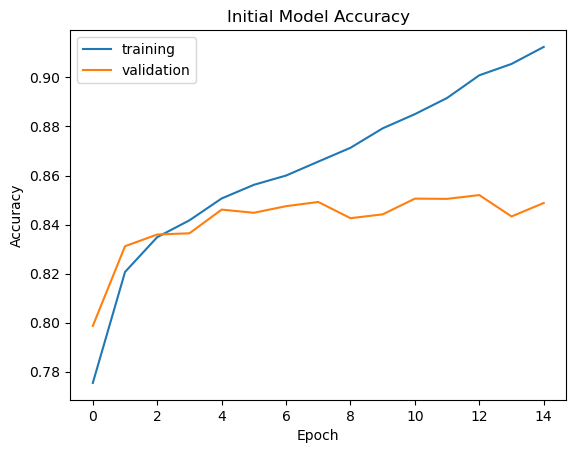

In [20]:
plt.plot(init_history.history['accuracy'], label='training')
plt.plot(init_history.history['val_accuracy'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Initial Model Accuracy')
plt.show()

Above we see that initial model accuracy is constantly increasing as the training goes on for the training set. However the validation set's accuracy seems to peeter out around epoch 4 where it hovers around 84%.

Below, we the the loss plot and notice the the loss for the validation set again starts to peeter out around epoch 4 at a loss of 0.35, whereas the training set loss keeps decreasing as training goes on. 

Therefore if this model would to be used, stopping the training around epoch 4 would yield the best result without the overfitting that we see after epoch 4.

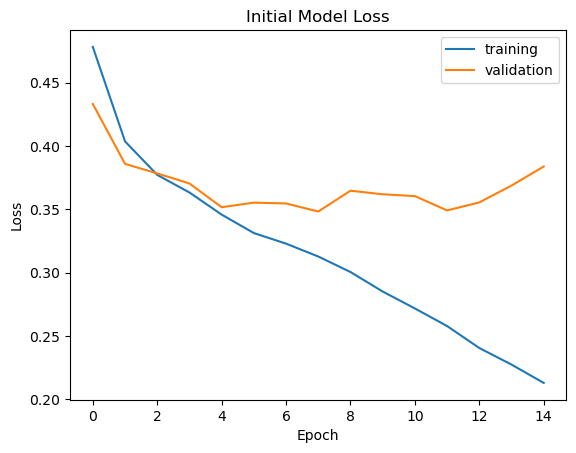

In [21]:
plt.plot(init_history.history['loss'], label='training')
plt.plot(init_history.history['val_loss'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Initial Model Loss')
plt.show()

## More Models

After the creation of the initial model, the VGG-esque model will become a little more VGG-like by repeating the [Conv, Conv, Pool] layers 2 more times. In theory this should be a better model based on known VGG architecture and should have better accuracy and a lower loss.

In [22]:
model2 = Sequential()

model2.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

model2.build(input_shape=(batch_size, 48, 48, 3))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (256, 46, 46, 25)         700       
                                                                 
 conv2d_3 (Conv2D)           (256, 44, 44, 25)         5650      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 22, 22, 25)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (256, 20, 20, 25)         5650      
                                                                 
 conv2d_5 (Conv2D)           (256, 18, 18, 25)         5650      
                                                                 
 max_pooling2d_2 (MaxPooling  (256, 9, 9, 25)          0         
 2D)                                                  

In [23]:
model2.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
history2 = model2.fit(train_data, validation_data=validate_data, epochs=15)

Epoch 1/15
688/688 [==============================] - 196s 283ms/step - loss: 0.4717 - accuracy: 0.7751 - val_loss: 0.3847 - val_accuracy: 0.8325
Epoch 2/15
688/688 [==============================] - 194s 282ms/step - loss: 0.3810 - accuracy: 0.8321 - val_loss: 0.3598 - val_accuracy: 0.8435
Epoch 3/15
688/688 [==============================] - 195s 284ms/step - loss: 0.3525 - accuracy: 0.8462 - val_loss: 0.3289 - val_accuracy: 0.8588
Epoch 4/15
688/688 [==============================] - 195s 284ms/step - loss: 0.3351 - accuracy: 0.8550 - val_loss: 0.3110 - val_accuracy: 0.8677
Epoch 5/15
688/688 [==============================] - 196s 285ms/step - loss: 0.3211 - accuracy: 0.8627 - val_loss: 0.3133 - val_accuracy: 0.8655
Epoch 6/15
688/688 [==============================] - 193s 280ms/step - loss: 0.3072 - accuracy: 0.8697 - val_loss: 0.2939 - val_accuracy: 0.8772
Epoch 7/15
688/688 [==============================] - 194s 281ms/step - loss: 0.2947 - accuracy: 0.8759 - val_loss: 0.2820 -

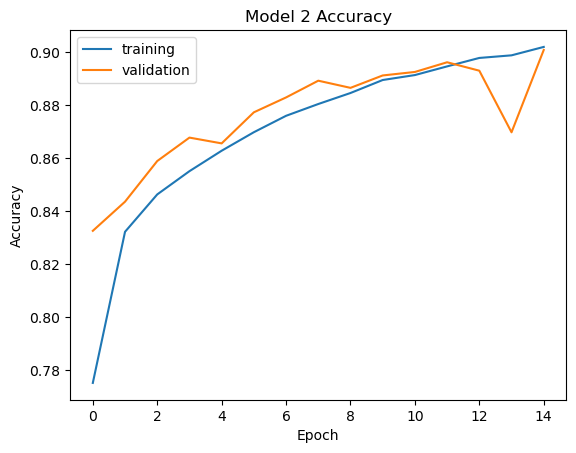

In [24]:
plt.plot(history2.history['accuracy'], label='training')
plt.plot(history2.history['val_accuracy'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 2 Accuracy')
plt.show()

Above we see the accuracy plot for the training and validation set for the second model. We notice an increase in the accuracy of both training and validation compared to the previous model with both reaching about 90% accuracy. Although there is a dip right before the training ended, it seems the model was starting to reach its end before it starts peetering out.

Below, we see the loss plot and notice that the loss is less for the validation set compared to the initial model, around 0.25.

If we assume the blip on the graph is not the sign of overtraining but variance in training, then we can say that the model at the end of the training is good enough instead of the model at epoch 11-12 being the best.

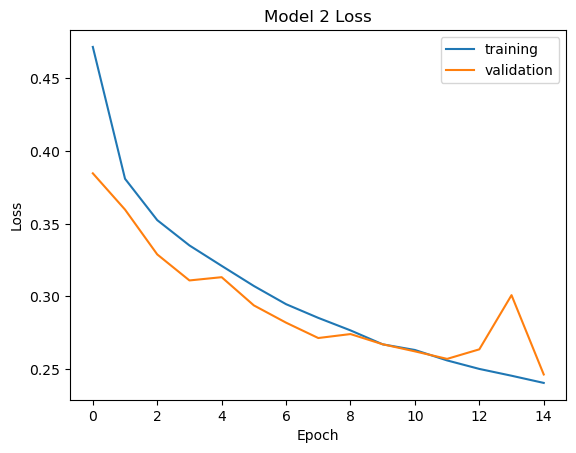

In [25]:
plt.plot(history2.history['loss'], label='training')
plt.plot(history2.history['val_loss'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 2 Loss')
plt.show()

Next, because we notice that the VGG-like model with 3 repeats of the [Conv, Conv, Pool] layer yielded the best results compared to the initial model with only one iteration of the trio, here we are going to see whether changing the hyperparameter, filter number, is going to affect the model or not. If we are able to test whether the smaller filter is able to yield the same or roughly the same result model 2, then we can make the model simpler and be able to run faster.

With that in mind, we are going to change the filter size from 25 to 5 to test the change.

In [26]:
model3 = Sequential()

model3.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=1, activation='sigmoid'))

model3.build(input_shape=(batch_size, 48, 48, 3))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (256, 46, 46, 5)          140       
                                                                 
 conv2d_9 (Conv2D)           (256, 44, 44, 5)          230       
                                                                 
 max_pooling2d_4 (MaxPooling  (256, 22, 22, 5)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (256, 20, 20, 5)          230       
                                                                 
 conv2d_11 (Conv2D)          (256, 18, 18, 5)          230       
                                                                 
 max_pooling2d_5 (MaxPooling  (256, 9, 9, 5)           0         
 2D)                                                  

In [27]:
model3.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
history3 = model3.fit(train_data, validation_data=validate_data, epochs=15)

Epoch 1/15
688/688 [==============================] - 113s 164ms/step - loss: 0.5104 - accuracy: 0.7514 - val_loss: 0.4716 - val_accuracy: 0.7871
Epoch 2/15
688/688 [==============================] - 113s 164ms/step - loss: 0.4639 - accuracy: 0.7894 - val_loss: 0.4536 - val_accuracy: 0.7948
Epoch 3/15
688/688 [==============================] - 112s 163ms/step - loss: 0.4548 - accuracy: 0.7951 - val_loss: 0.4534 - val_accuracy: 0.7950
Epoch 4/15
688/688 [==============================] - 114s 165ms/step - loss: 0.4483 - accuracy: 0.7977 - val_loss: 0.4462 - val_accuracy: 0.7987
Epoch 5/15
688/688 [==============================] - 114s 166ms/step - loss: 0.4434 - accuracy: 0.8010 - val_loss: 0.4379 - val_accuracy: 0.8029
Epoch 6/15
688/688 [==============================] - 117s 170ms/step - loss: 0.4321 - accuracy: 0.8070 - val_loss: 0.4260 - val_accuracy: 0.8097
Epoch 7/15
688/688 [==============================] - 116s 168ms/step - loss: 0.4258 - accuracy: 0.8102 - val_loss: 0.4260 -

The amount of time spent training did decrease from around 195 seconds (3min 15 secs) to around 115 seconds (1 min 55 sec). The time difference can add up in the long run.

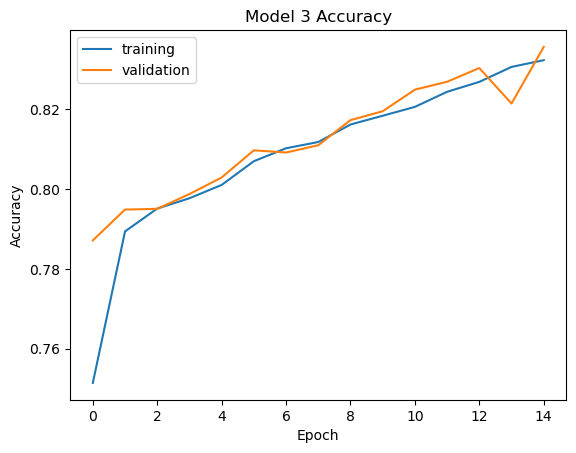

In [28]:
plt.plot(history3.history['accuracy'], label='training')
plt.plot(history3.history['val_accuracy'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 3 Accuracy')
plt.show()

We see for the accuracy plot that both training and validation set accuracy looks to be still increasing and has not shown signs of the 'elbow' when the change in accuracy starts to decrease. This tells us that with less filters, more training has to be done. According to the training records before the plot we see that the end accuracy is 83.5% for both data sets. This is less than our second model given the current training. 

Similar results can be seen in the loss plot. The loss looks like it can still go down further and does not look like it has reached the 'elbow' phase yet. Loss is around ~ 0.37 for the validation set. 

This just goes to show that a model with less filters needs to be trained longer.

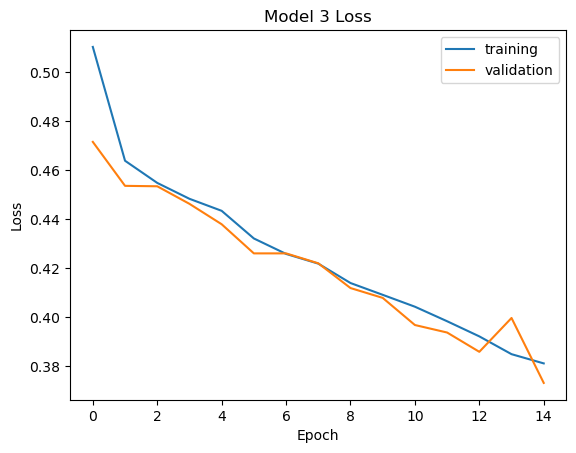

In [29]:
plt.plot(history3.history['loss'], label='training')
plt.plot(history3.history['val_loss'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 3 Loss')
plt.show()

The fourth model here is going to retain the same filters as the second model but here we are going to add batch normalizations after each Conv layer. Batch normalization is often used to make the model faster by normalizing the layers.

In [30]:
model4 = Sequential()

model4.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Flatten())
model4.add(Dense(units=256, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

model4.build(input_shape=(batch_size, 48, 48, 3))
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (256, 46, 46, 25)         700       
                                                                 
 batch_normalization (BatchN  (256, 46, 46, 25)        100       
 ormalization)                                                   
                                                                 
 conv2d_15 (Conv2D)          (256, 44, 44, 25)         5650      
                                                                 
 batch_normalization_1 (Batc  (256, 44, 44, 25)        100       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (256, 22, 22, 25)        0         
 2D)                                                             
                                                      

In [31]:
model4.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
history4 = model4.fit(train_data, validation_data=validate_data, epochs=15)

Epoch 1/15
688/688 [==============================] - 253s 365ms/step - loss: 0.3805 - accuracy: 0.8328 - val_loss: 0.6522 - val_accuracy: 0.7191
Epoch 2/15
688/688 [==============================] - 250s 364ms/step - loss: 0.3012 - accuracy: 0.8736 - val_loss: 0.3143 - val_accuracy: 0.8644
Epoch 3/15
688/688 [==============================] - 251s 364ms/step - loss: 0.2676 - accuracy: 0.8886 - val_loss: 0.7451 - val_accuracy: 0.7611
Epoch 4/15
688/688 [==============================] - 251s 365ms/step - loss: 0.2534 - accuracy: 0.8951 - val_loss: 0.9703 - val_accuracy: 0.7205
Epoch 5/15
688/688 [==============================] - 250s 364ms/step - loss: 0.2423 - accuracy: 0.9007 - val_loss: 0.5799 - val_accuracy: 0.8015
Epoch 6/15
688/688 [==============================] - 250s 364ms/step - loss: 0.2303 - accuracy: 0.9060 - val_loss: 0.6625 - val_accuracy: 0.7912
Epoch 7/15
688/688 [==============================] - 251s 365ms/step - loss: 0.2233 - accuracy: 0.9093 - val_loss: 0.3043 -

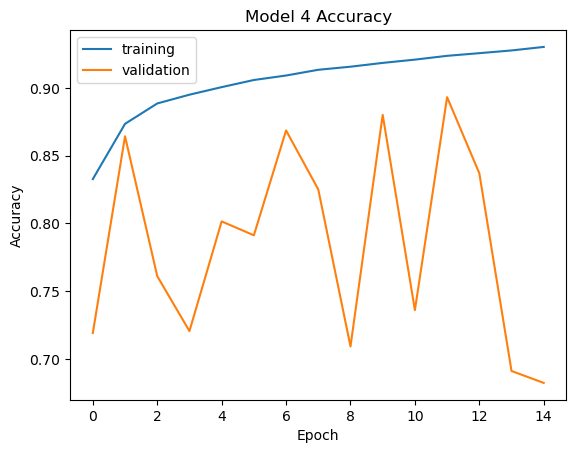

In [32]:
plt.plot(history4.history['accuracy'], label='training')
plt.plot(history4.history['val_accuracy'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 4 Accuracy')
plt.show()

The result of the batch normalization layers does make the training accuracy and loss to look smoother. However it made the training longer 195 seconds to 250 seconds contrary to belief. It also made the validation accuracy and loss look very wonky and has a lot of variance. That is, comparing using only the training data set, we see that batch normalization increased the accuracy and decreased loss the most out of the the other 3 models from before. However, we can't simply be looking at the training data set only because there may be signs of overfitting. That's why we also look at the validation set and unfortunately we see this - a plot with a lot of big changes each epoch.

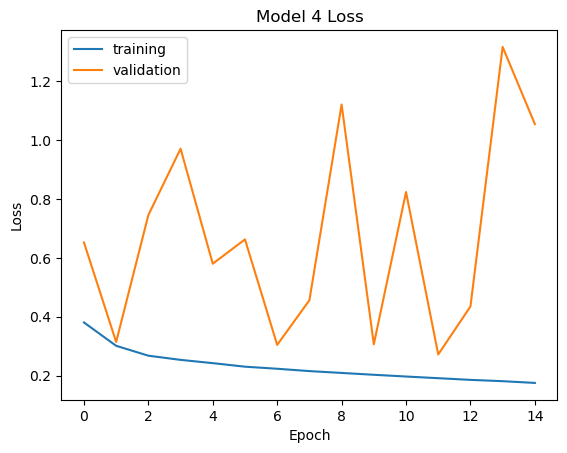

In [33]:
plt.plot(history4.history['loss'], label='training')
plt.plot(history4.history['val_loss'], label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 4 Loss')
plt.show()

## Results

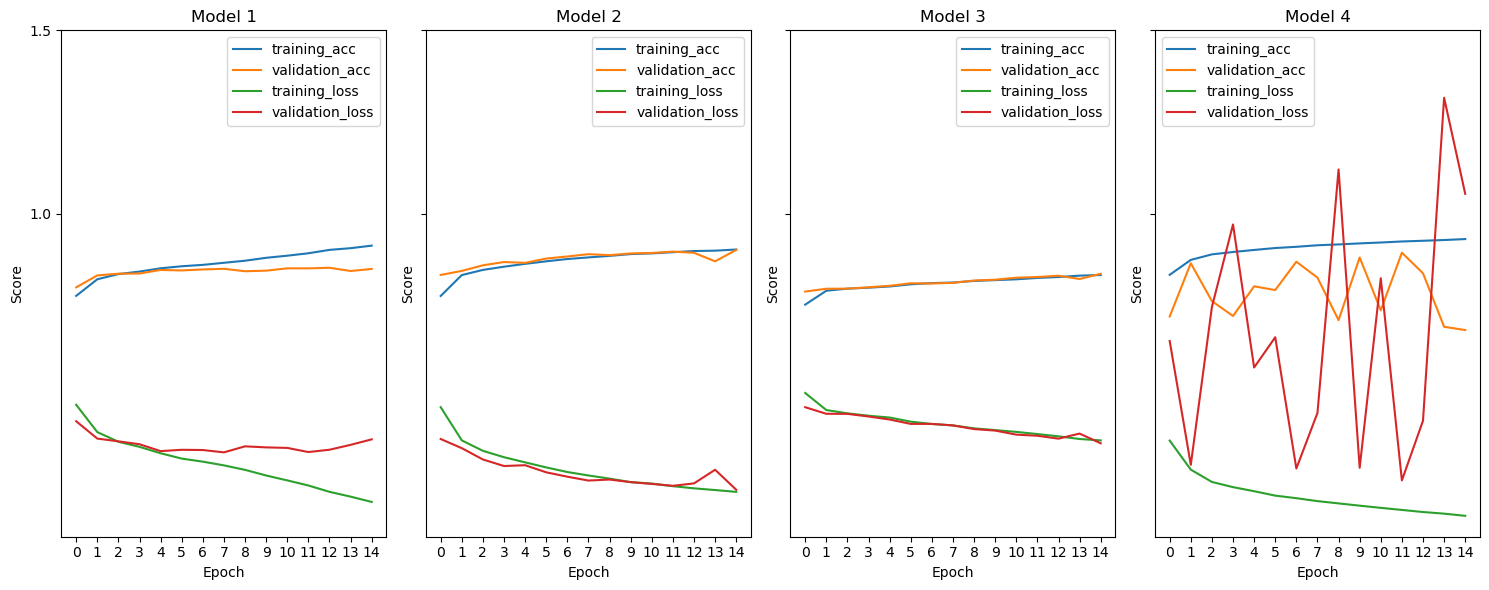

In [84]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6), sharey=True, sharex=True)

axs[0].plot(init_history.history['accuracy'], label='training_acc')
axs[0].plot(init_history.history['val_accuracy'], label='validation_acc')
axs[0].plot(init_history.history['loss'], label='training_loss')
axs[0].plot(init_history.history['val_loss'], label='validation_loss')
axs[0].set_title('Model 1')
axs[0].legend()

axs[1].plot(history2.history['accuracy'], label='training_acc')
axs[1].plot(history2.history['val_accuracy'], label='validation_acc')
axs[1].plot(history2.history['loss'], label='training_loss')
axs[1].plot(history2.history['val_loss'], label='validation_loss')
axs[1].legend()
axs[1].set_title('Model 2')

axs[2].plot(history3.history['accuracy'], label='training_acc')
axs[2].plot(history3.history['val_accuracy'], label='validation_acc')
axs[2].plot(history3.history['loss'], label='training_loss')
axs[2].plot(history3.history['val_loss'], label='validation_loss')
axs[2].legend()
axs[2].set_title('Model 3')

axs[3].plot(history4.history['accuracy'], label='training_acc')
axs[3].plot(history4.history['val_accuracy'], label='validation_acc')
axs[3].plot(history4.history['loss'], label='training_loss')
axs[3].plot(history4.history['val_loss'], label='validation_loss')
axs[3].legend()
axs[3].set_title('Model 4')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Score')


plt.setp(axs, xticks=list(range(0, 15)), xticklabels=list(range(0, 15)),
        yticks=[1, 1.5])

plt.tight_layout()
plt.show()

In summary we see that model 2 is the better overall choice for our final model because it has a higher accuracy (validation-set-wise), lower loss, and looks to be much stabler that the other models. We are going to use model 2 as is without retraining it to a lower epoch.

In [92]:
import os
images_test = pd.DataFrame({'id':os.listdir(test_path)})

images_test.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [93]:
# normalizing the images
image_gen_test = ImageDataGenerator(rescale=1./255.)

# obtaining training data
test_data = image_gen_test.flow_from_dataframe(
    dataframe=images_test,
    directory=test_path,
    x_col='id',
    target_size=(48, 48),
    class_mode=None,
    batch_size=batch_size
)

Found 57458 validated image filenames.


In [95]:
pred = model2.predict(test_data, verbose=1)

225/225 [==============================] - 174s 778ms/step


In [96]:
print(pred)

[[0.08006816]
 [0.00439299]
 [0.01484756]
 ...
 [0.985059  ]
 [0.5656815 ]
 [0.07925731]]


In [99]:
pred = np.transpose(pred)[0]

In [105]:
submission = pd.DataFrame()
submission['id'] = images_test.id.apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x<0.5 else 1, pred))

In [106]:
submission.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [107]:
submission.to_csv('submission.csv', index=False)

After submitting the test images, the result was an accuracy of 50%.

## Discussion

Looking back, there were a couple things I could have done to possibly get better results. First was rescaling the images. During the data streaming, the image is resized to a 48x48 image instead - that's around half of the original image size. Because of the image reduction, it probably made it harder for the model to detect the cancer cells considering that some became too small to detect or was simply erased for the resizing to occur. Perhaps in a different trial, the size should be a little bigger. Perhaps even not resize at all. However that presents the issue where training may take too long and it becomes a menace of a model that is simply impractical to fix constantly because it takes forever to finish. 

The second issue was the issue of target. Meaning that the labels were based on the presence of cancer cells within the 32x32 square in the middle of the image. Instead of looking and training the whole image, would it not be better to instead crop out that part of the image and train the models based on that? That way, the size of the image would be smaller, 32x32, but also the features of that area would remain unchanged because there was no resizing and thus no change to that part of the image. This presents another image though. The problem with this is that issue of space/memory. Because there were too many images, 200k+ images, cropping out all those images and saving it to another directory would take so much space. If there was a way to crop the image and feed that into the model training without wasting memory, then I think this would have better results.


## Conclusion

Overall, from the model development, we see that a VGG-esque model architecture is a very good architecture that yields good results for image analysis. The proof is the stable model 2 with 3 repeats of [Conv, Conv, Pool] layers with an validation accuracy of 0.9 and loss of 0.25. We see also learn that changing the filters reduces the time spent per epoch but requires more training. Because the epoch length was set at 15, we couldn't compare how long it really took to completely train. Finally we see that batch normalization showed a smoother training train/loss curve but vastly varied in the validation set. 

Most importantly, we see the value in considering our model inputs. Changing what is put into the image model will produce different results for better or worse. 